# Melanoma Skin Cancer Detection and Classification Using Support Vector Machine (SVM)

#### Objective: The main goal of this project is to develop an automated system that can detect and classify melanoma skin cancer from dermoscopy images. Early diagnosis of melanoma, the most aggressive form of skin cancer, is crucial for effective treatment. This project implements methods from the referenced article by Alquran et al. (2017) to build a classification system based on image processing and machine learning, specifically Support Vector Machine (SVM).

#### Article link : https://www.researchgate.net/publication/319289816_The_Melanoma_Skin_Cancer_Detection_and_Classification_Using_Support_Vector_Machine

### Methodology: The project follows a systematic approach involving several stages:

##### - Image Preprocessing: Converts images to grayscale, applies histogram modification, and uses noise filtering to enhance contrast.
##### - Segmentation: egment the Region of Interest (ROI) using Otsu thresholding, followed by filling and opening operations to isolate the lesion area, making the melanoma features clear for further analysis .
##### - Feature Extraction: Extracts relevant features (texture, color, shape) from the segmented lesion using methods like the Gray Level Co-occurrence Matrix (GLCM) and ABCD parameters (Asymmetry, Border, Color, and Diameter).
##### - Dimensionality Reduction: Uses Principal Component Analysis (PCA) to select the most significant features for efficient classification.
##### - Classification with SVM: Trains the SVM classifier to categorize lesions as benign or malignant based on the extracted features.

In [1]:
# Import necessary libraries for image processing and machine learning
import os
import time
import shutil
import pathlib
import itertools

from PIL import Image
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from scipy.stats import skew, kurtosis, entropy

import warnings
warnings.filterwarnings("ignore")


# ------------------------------------------------------------------
# **Step 1: Creating the DataFrame with paths and labels**
# ------------------------------------------------------------------

In [2]:
data_dir = r'C:\Users\elhas\ML Project\DataSet'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis= 1)
data_df

,filepaths,labels
0,C:\Users\elhas\ML Project\DataSet\Benign\1.jpg,Benign
1,C:\Users\elhas\ML Project\DataSet\Benign\10.jpg,Benign
2,C:\Users\elhas\ML Project\DataSet\Benign\100.jpg,Benign
3,C:\Users\elhas\ML Project\DataSet\Benign\1000.jpg,Benign
4,C:\Users\elhas\ML Project\DataSet\Benign\1001.jpg,Benign
...,...,...
33874,C:\Users\elhas\ML Project\DataSet\Malignant\au...,Malignant
33875,C:\Users\elhas\ML Project\DataSet\Malignant\au...,Malignant
33876,C:\Users\elhas\ML Project\DataSet\Malignant\au...,Malignant
33877,C:\Users\elhas\ML Project\DataSet\Malignant\au...,Malignant


#### Distribution of Benign and Malignant Labels in the Dataset

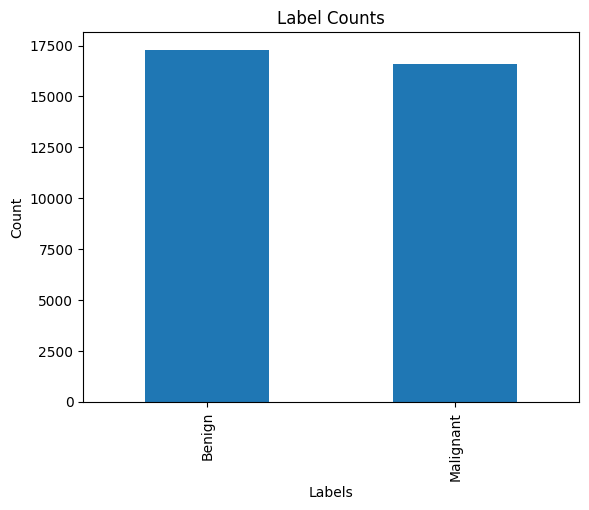

In [3]:

label_counts = data_df['labels'].value_counts()
label_counts_df = pd.DataFrame(label_counts)

label_counts_df.plot(kind='bar', legend=False)
plt.title('Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [4]:
data_df.duplicated().sum()

0

In [5]:
data_df.isnull().sum()

filepaths    0
labels       0
dtype: int64

In [6]:
data_df['labels'].value_counts()

labels
Benign       17289
Malignant    16590
Name: count, dtype: int64

# -----------------------------------------
# **Step 2: Preprocessing the images**
# -----------------------------------------

In [7]:

output_dir = r'C:\Users\elhas\ML Project\DataSet\train_preprocessed'
os.makedirs(output_dir, exist_ok=True)

# Appliquer le prétraitement pour chaque image dans data_df
for idx, row in data_df.iterrows():
    input_path = row['filepaths']
    label = row['labels']
    
    # Charger l'image
    image = cv2.imread(input_path)
    
    # 1. Convert the image to grayscale for simpler processing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Apply histogram equalization to enhance contrast in the grayscale image
    equalized_image = cv2.equalizeHist(gray_image)

    # 3. Use median filtering to reduce noise in the image
    filtered_image = cv2.medianBlur(equalized_image, 5)

    label_output_dir = os.path.join(output_dir, label)
    os.makedirs(label_output_dir, exist_ok=True)
    
    output_path = os.path.join(label_output_dir, os.path.basename(input_path))
    cv2.imwrite(output_path, filtered_image)

print("Preprocessing applied and images saved.")

Preprocessing applied and images saved.


# ---------------------------------------------------------
# **Example of the preprocessed image results**
# --------------------------------------------------------


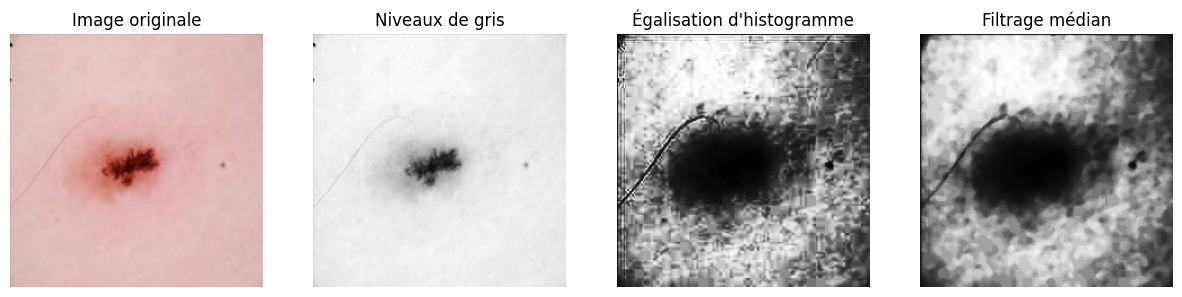

In [8]:

example_path = data_df['filepaths'].iloc[0]
original_image = cv2.imread(example_path)


gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)


equalized_image = cv2.equalizeHist(gray_image)


filtered_image = cv2.medianBlur(equalized_image, 5)


plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title("Image originale")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Niveaux de gris")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Égalisation d'histogramme")
plt.imshow(equalized_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Filtrage médian")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()


# -----------------------------------------
# **Step 3: Image Segmentation**
# -----------------------------------------

In [9]:

segmented_output_dir = r'C:\Users\elhas\ML Project\DataSet\segmented_images'
os.makedirs(segmented_output_dir, exist_ok=True)


for idx, row in data_df.iterrows():
    # Charger l'image prétraitée
    image_path = row['filepaths']
    label = row['labels']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 1. Apply Otsu's thresholding to segment the lesion   
    _, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 2. Fill in regions within the detected lesion to create a solid region    
    filled_image = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

    # 3. Apply morphological opening to smooth the lesion boundaries    
    opened_image = cv2.morphologyEx(filled_image, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

    # 4. Convert to grayscale (already in grayscale) and apply histogram equalization    
    gray_roi = opened_image  
    equalized_roi = cv2.equalizeHist(gray_roi)

   
    label_output_dir = os.path.join(segmented_output_dir, label)
    os.makedirs(label_output_dir, exist_ok=True)

    
    output_path = os.path.join(label_output_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, equalized_roi)

print("Segmentation applied and images saved.")



Segmentation applied and images saved.


# ---------------------------------------------
# **Example of the segmentation results**
# ---------------------------------------------


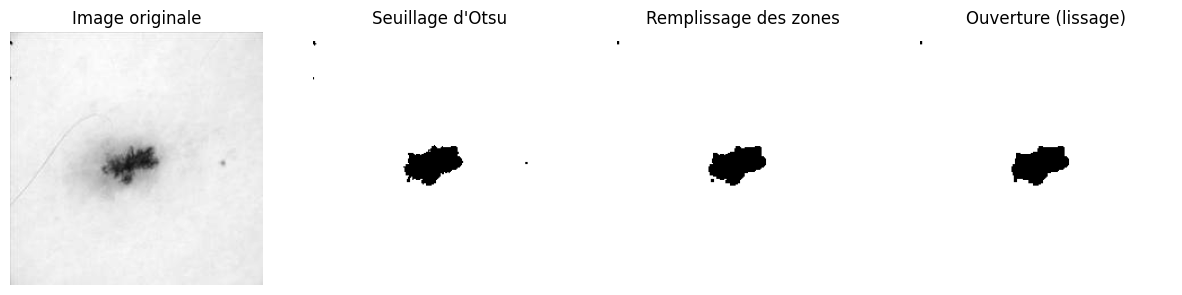

In [10]:
image_path = data_df['filepaths'].iloc[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

filled_image = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

opened_image = cv2.morphologyEx(filled_image, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Seuillage d'Otsu")
plt.imshow(otsu_thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Remplissage des zones")
plt.imshow(filled_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Ouverture (lissage)")
plt.imshow(opened_image, cmap='gray')
plt.axis('off')

plt.show()


# ---------------------------------------
# **Step 4: Feature Extraction**
# --------------------------------------

In [11]:


features = []


for idx, row in data_df.iterrows():
    image_path = row['filepaths']
    label = row['labels']

    # Phase 1: Color Feature Extraction (RGB)
    image_rgb = cv2.imread(image_path)
    if image_rgb is None:
        continue  # Sauter si l'image n'est pas chargée correctement

    mean_red = np.mean(image_rgb[:, :, 2])
    mean_green = np.mean(image_rgb[:, :, 1])
    mean_blue = np.mean(image_rgb[:, :, 0])

    # Convert the RGB image to grayscale for further processing
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

    if np.sum(image_gray) == 0:
        continue  # Sauter les images vides

    # Phase 2: Shape Feature Extraction
    # Find contours in the grayscale image
    contours, _ = cv2.findContours(image_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = contours[0]
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
        cy = int(M['m01'] / M['m00']) if M['m00'] != 0 else 0
        asymmetry = np.mean([cv2.pointPolygonTest(cnt, (cx, cy), True) for point in cnt])
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if area != 0 else 0
        _, _, w, h = cv2.boundingRect(cnt)
        diameter = max(w, h)

    # Phase 3: Texture Feature Extraction using Gray-Level Co-occurrence Matrix (GLCM)
    # Compute GLCM with specified distances and angles
    glcm = graycomatrix(image_gray, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Phase 4: Statistical Feature Extraction
    # Enhance contrast of the grayscale image using histogram equalization
    equalized_image = cv2.equalizeHist(image_gray)
    hist_values, _ = np.histogram(equalized_image.ravel(), bins=256)
    hist_entropy = entropy(hist_values)
    hist_skewness = skew(equalized_image.ravel())
    hist_kurtosis = kurtosis(equalized_image.ravel())
    hist_mean = np.mean(equalized_image.ravel())

    # Store all extracted features in a dictionary
    features.append({
        'filepath': image_path,
        'label': label,
        'mean_red': mean_red,
        'mean_green': mean_green,
        'mean_blue': mean_blue,
        'asymmetry': asymmetry,
        'perimeter': perimeter,
        'circularity': circularity,
        'diameter': diameter,
        'contrast': contrast,
        'homogeneity': homogeneity,
        'energy': energy,
        'correlation': correlation,
        'hist_entropy': hist_entropy,
        'hist_skewness': hist_skewness,
        'hist_kurtosis': hist_kurtosis,
        'hist_mean': hist_mean
    })

# Create a DataFrame from the list of features extracted
features_df = pd.DataFrame(features)
print(features_df.head())


                                            filepath   label    mean_red  \
0     C:\Users\elhas\ML Project\DataSet\Benign\1.jpg  Benign  222.904516   
1    C:\Users\elhas\ML Project\DataSet\Benign\10.jpg  Benign  239.815310   
2   C:\Users\elhas\ML Project\DataSet\Benign\100.jpg  Benign  174.837353   
3  C:\Users\elhas\ML Project\DataSet\Benign\1000.jpg  Benign  225.981226   
4  C:\Users\elhas\ML Project\DataSet\Benign\1001.jpg  Benign  208.033861   

   mean_green   mean_blue  asymmetry  perimeter  circularity  diameter  \
0  181.230808  179.081732      111.0      892.0     0.785398       224   
1  154.168029  172.427714      111.0      892.0     0.785398       224   
2  156.435686  175.963887      111.0      892.0     0.785398       224   
3  134.279217  148.957131      111.0      892.0     0.785398       224   
4  120.689712  132.399514      111.0      892.0     0.785398       224   

    contrast  homogeneity    energy  correlation  hist_entropy  hist_skewness  \
0   9.582419     

In [12]:
# Save the features DataFrame to a CSV file
features_df.to_csv('features_df1.csv', index=False)

# ------------------------------------------
# **Step 5-1: Classification with SVM**
# -----------------------------------------

In [17]:

# Load the extracted features into a DataFrame
features_df = pd.DataFrame(features)  

# Separate the data into features (X) and labels (y)
X = features_df.drop(columns=['filepath', 'label'])  
y = features_df['label']  


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the split datasets to CSV files for future use

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


Cross-validation scores: [0.76646375 0.7695997  0.76793949 0.77343173 0.76937269]
Mean cross-validation score: 0.7693614759058491
Classification report:
               precision    recall  f1-score   support

       Benin       0.80      0.74      0.77      3469
       Malin       0.75      0.80      0.78      3307

    accuracy                           0.77      6776
   macro avg       0.77      0.77      0.77      6776
weighted avg       0.78      0.77      0.77      6776

Test set accuracy: 0.773465171192444


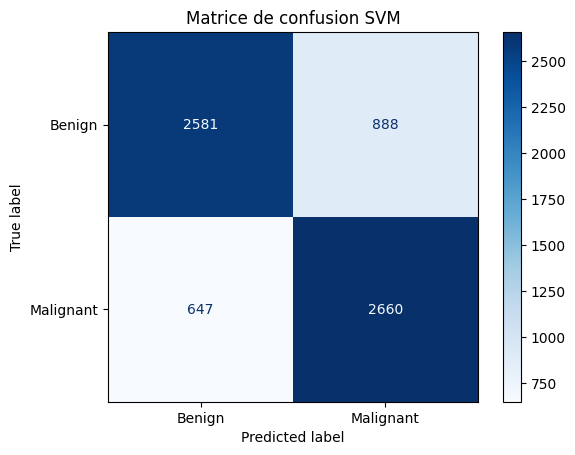

In [18]:
# Initialize the SVM classifier with a Gaussian kernel
svm_model = SVC(kernel='rbf', gamma='scale', C=1)

# Train the model with cross-validation
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)  
print("Cross-validation scores:", cv_scores) 
print("Mean cross-validation score:", cv_scores.mean())  

# Fit the final model on the entire training set
svm_model.fit(X_train, y_train)  

# Make predictions on the test set
y_pred = svm_model.predict(X_test)  

# Display the classification report
print("Classification report:\n", classification_report(y_test, y_pred, target_names=['Benin', 'Malin']))  
print("Test set accuracy:", accuracy_score(y_test, y_pred)) 

# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_) 
disp.plot(cmap='Blues')
plt.title("Matrice de confusion SVM")
plt.savefig('confusion_matrixSVM.png')  
plt.show()  

# ---------------------------------------------------
# **Step 5-2: Classification with SVM and PCA**
# ---------------------------------------------------

Cross-validation scores with PCA: [0.78269692 0.79524073 0.78159011 0.7902214  0.79575646]
Mean cross-validation score with PCA: 0.7891011244368116
Classification report:
               precision    recall  f1-score   support

       Benin       0.81      0.78      0.79      3469
       Malin       0.78      0.81      0.79      3307

    accuracy                           0.79      6776
   macro avg       0.79      0.79      0.79      6776
weighted avg       0.79      0.79      0.79      6776

Test set accuracy with PCA: 0.7933884297520661


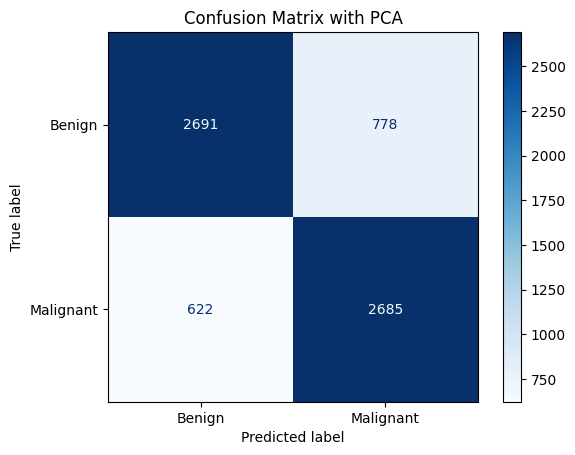

In [20]:

# Load the previously saved datasets
X_train = pd.read_csv('X_train.csv') 
X_test = pd.read_csv('X_test.csv')    
y_train = pd.read_csv('y_train.csv')  
y_test = pd.read_csv('y_test.csv')    

# Apply PCA to reduce the dimensionality to 5 principal components
pca = PCA(n_components=5)  
X_train_pca = pca.fit_transform(X_train) 
X_test_pca = pca.transform(X_test)  

# Create and train the SVM model with cross-validation on the reduced data
svm_model = SVC(kernel='rbf', gamma='scale', C=1)  
cv_scores = cross_val_score(svm_model, X_train_pca, y_train.values.ravel(), cv=5)  
print("Cross-validation scores with PCA:", cv_scores)  
print("Mean cross-validation score with PCA:", cv_scores.mean())  

# Train the final model and make predictions
svm_model.fit(X_train_pca, y_train.values.ravel())  
y_pred = svm_model.predict(X_test_pca)  

# Display the classification report
print("Classification report:\n", classification_report(y_test, y_pred, target_names=['Benin', 'Malin']))  
print("Test set accuracy with PCA:", accuracy_score(y_test, y_pred))  
 

# Compute and display the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=svm_model.classes_) 
disp.plot(cmap='Blues')
plt.title('Confusion Matrix with PCA') 
plt.savefig('confusion_matrixSVM_PCA.png')
plt.show()  